# 離散化による2期間モデルの解法

このノートブックは経済セミナー連載、**定量的マクロ経済学と数値計算**において公開されているコードをJuliaで実装したものです。Julia likeな書き方としましたが、それ以外については公開されているMATLABのコードに基づいています。


In [1]:
versioninfo()

Julia Version 1.1.0
Commit 80516ca202 (2019-01-21 21:24 UTC)
Platform Info:
  OS: Windows (x86_64-w64-mingw32)
  CPU: Intel(R) Core(TM) i7-7500U CPU @ 2.70GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-6.0.1 (ORCJIT, skylake)


In [2]:
using LinearAlgebra
using Optim #最適化
using Roots #求根
using LeastSquaresOptim #射影法
using BenchmarkTools 
using Plots
gr()

Plots.GRBackend()

## 共通要素について

以降考えるモデルは共通かつパラメータも同じなので、繰り返し同じコードを避けるためにパラメータをあらかじめ設定する。

In [3]:
struct Models{TI<:Int, TF<:AbstractFloat, TV<:Vector}
    #パラメータ
    β::TF #割引因子
    γ::TF #相対的危険回避度
    
    #要素価格
    rent::TF #純利子率
    
    #グリッド
    nw::TI #所得グリッドの数
    w_max::TF #所得グリッドの最大値
    w_min::TF #所得グリッドの最小値
    grid_w::TV #所得グリッド
    na::TI　#貯蓄グリッドの数
    a_max::TF　#貯蓄グリッドの最大値
    a_min::TF　#貯蓄グリッドの最小値
    grid_a::TV　#貯蓄グリッド
end

In [4]:
function Constract(;β=0.985^30,
                γ=2.0, 
                rent= 1.025^30 - 1.0, 
                nw = 10, 
                w_max = 1.0, 
                w_min = 0.1, 
                na = 40, 
                a_max = 1.0, 
                a_min = 0.025) 
    grid_w = collect(LinRange(w_min, w_max, nw))
    grid_a = collect(LinRange(a_min, a_max, na))
    
    return Models(β, γ, rent, nw, w_max, w_min, grid_w, na, a_max, a_min, grid_a)
end

Constract (generic function with 1 method)

In [5]:
model = Constract()

Models{Int64,Float64,Array{Float64,1}}(0.6354580927313495, 2.0, 1.097567579081788, 10, 1.0, 0.1, [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 40, 1.0, 0.025, [0.025, 0.05, 0.075, 0.1, 0.125, 0.15, 0.175, 0.2, 0.225, 0.25  …  0.775, 0.8, 0.825, 0.85, 0.875, 0.9, 0.925, 0.95, 0.975, 1.0])

In [6]:
function CRRA(cons,γ::Float64)
    """
    効用関数
    
    # インプット
    cons: 消費
    γ: 相対的リスク回避度
    
    # アウトプット
    効用
    """
    if γ != 1.0
        return cons^(1.0 -γ)/(1.0 -γ) 
    else
        return log(cons)
    end
end

CRRA (generic function with 1 method)

In [7]:
util2 = model.β*CRRA.((1.0+model.rent)*model.grid_a, model.γ);

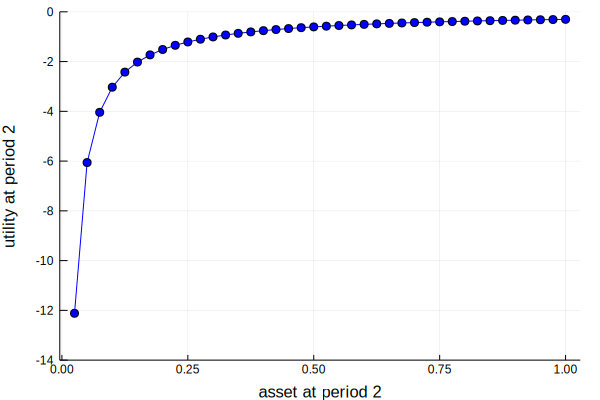

In [8]:
plot(model.grid_a,util2, color=:blue,marker=:circle, legend = false)
ylims!((-14,0))
xlabel!("asset at period 2")
ylabel!("utility at period 2")

## 離散化による解法

In [9]:
function discretize(m::Models)
    """
    2期間モデルを離散化によって解く
    
    # インプット
    `m::Models`::パラメータの構造体
    
    # アウトプット
    `obj::Vector`::価値関数
    `pol::Vector`::政策関数
    """
    
    #配列をあらかじめ定義しておく
    obj = zeros(m.na, m.nw) #価値関数
    pol = zeros(m.nw) #政策関数
    
    #あらゆる(w,a)の組み合わせについて生涯効用を計算
    @inbounds for i in 1:m.nw
        @inbounds for j in 1:m.na
            cons = m.grid_w[i] - m.grid_a[j]
            if cons > 0.0
                obj[j, i] = CRRA(cons, m.γ) + m.β* CRRA((1.0+m.rent)*m.grid_a[j], m.γ)
            else
                obj[j,i] = -10000.0 #負の消費についてペナルティ
            end
        end
    end
    
    #各wについて生涯効用を最大とするようなaを探す
    @inbounds for i in 1:m.nw
        maxv, maxl = findmax(obj[:,i]);
        pol[i] = m.grid_a[maxl];
    end

    
    return obj,pol
end

discretize (generic function with 1 method)

In [10]:
obj, pol = discretize(model);

In [11]:
@benchmark discretize(model)

BenchmarkTools.Trial: 
  memory estimate:  7.34 KiB
  allocs estimate:  13
  --------------
  minimum time:     5.348 μs (0.00% GC)
  median time:      5.995 μs (0.00% GC)
  mean time:        8.771 μs (21.37% GC)
  maximum time:     10.178 ms (99.92% GC)
  --------------
  samples:          10000
  evals/sample:     6

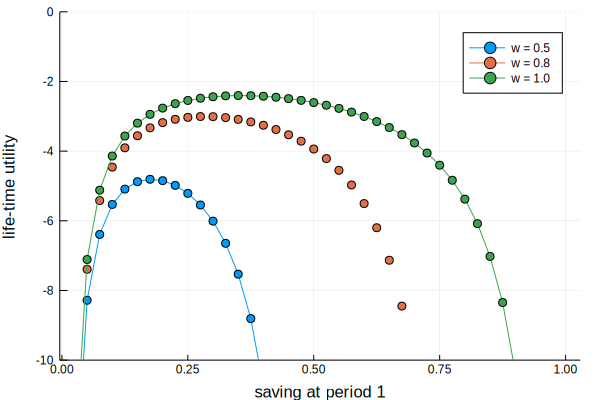

In [12]:
plot(model.grid_a, obj[:,5], marker=:circle, label = "w = 0.5")
plot!(model.grid_a, obj[:,8], marker=:circle, label = "w = 0.8")
plot!(model.grid_a, obj[:,10], marker=:circle, label = "w = 1.0")
ylabel!("life-time utility")
xlabel!("saving at period 1")
ylims!((-10.0, 0.0))

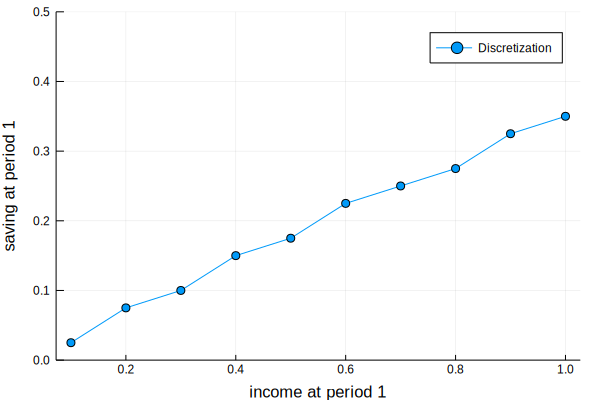

In [13]:
plot(model.grid_w,pol, marker=:circle,label="Discretization")
ylims!((0,0.5))
xlabel!("income at period 1")
ylabel!("saving at period 1")

## 最適化

**注意**

MATLABのドキュメントによれば経セミで利用されている2種類の関数のアルゴリズムは次のようになっている。
1. *fminbnb*:Brent's method
2. *fminsearch*:Nelder-Mead method

しかしJuliaにおいては1変数関数についてNelder-Mead methodは利用できない。(`Optim.jl`が1変数の最小化については区間を利用するような最適化しか対応していない(?))

そのため最適化関数による比較はここでは出来ないことに注意。



In [14]:
function obj_two_period(a, w_val, m::Models)
    """
    所得wを所与として、2期間モデルの生涯効用を返す
    
    # インプット
    `a::Real`: 貯蓄水準
    `w_val::Real`: 所得水準
    `m::Models`: パラメータを含む構造体
    
    # アウトプット
    生涯効用:
    """
    #1期目の効用
    if w_val - a > 0.0 
        util_y = CRRA(w_val - a, m.γ)
    else
        util_y = -1000000.0 #負の消費に対するペナルティ
    end
    
    # 2期目の割引効用
    util_o = m.β*CRRA((1.0+m.rent)*a, m.γ)
    
    # optimizeが最小値を探すので、マイナスを書けることで最適な値を求める。
    return  -1.0*(util_y + util_o)
end

obj_two_period (generic function with 1 method)

In [15]:
function optimization(m::Models)
    """
    政策関数を最適化を用いて求める
    
    # インプット
    `m::Models`:パラメータを含む構造体
    # アウトプット
    `a_gs::Vector`政策関数
    """
    a_gs = zeros(m.nw)
    
    # 各wについて目的関数を最大にするような貯蓄水準を求める
    for (w_ind, w_val) in enumerate(m.grid_w)
        obj_two_period!(a) = obj_two_period(a, w_val, m)
        #黄金分割法により計算
        res = optimize(obj_two_period!, w_val*0.01, w_val*2.0, GoldenSection()) 
        a_gs[w_ind] = res.minimizer
    end
    return a_gs
end

optimization (generic function with 1 method)

In [16]:
a_gs = optimization(model)

10-element Array{Float64,1}:
 0.035500888178047925
 0.07100177635609585 
 0.10650266453414378 
 0.1420035527121917  
 0.17750444089023965 
 0.21300532906828756 
 0.24850621724633548 
 0.2840071054243834  
 0.3195079857755279  
 0.3550088817804793  

In [17]:
@benchmark optimization(model)

BenchmarkTools.Trial: 
  memory estimate:  2.19 KiB
  allocs estimate:  31
  --------------
  minimum time:     10.931 μs (0.00% GC)
  median time:      11.989 μs (0.00% GC)
  mean time:        13.692 μs (12.36% GC)
  maximum time:     16.940 ms (99.89% GC)
  --------------
  samples:          10000
  evals/sample:     1

In [18]:
#解析解
coef1 = (model.β*(1.0+model.rent))^(-1.0/model.γ);
coef2 = 1.0/(1.0+coef1*(1.0+model.rent));
a_cfs = coef2*model.grid_w;

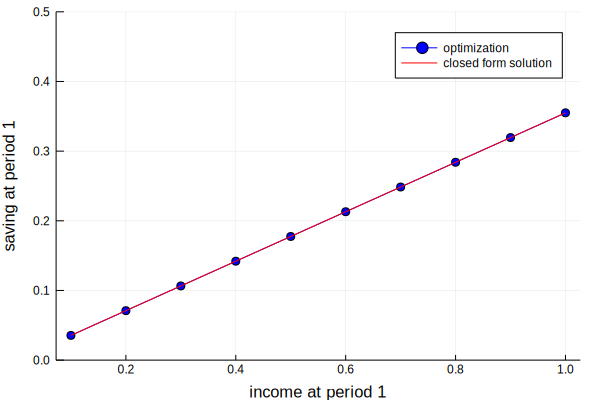

In [19]:
plot(model.grid_w, a_gs, color = :blue, marker=:circle, label="optimization")
plot!(model.grid_w, a_cfs, color = :red, label="closed form solution" )
ylims!((0, 0.5))
xlabel!("income at period 1")
ylabel!("saving at period 1")

## 求根アルゴリズム

In [20]:
function mu_CRRA(cons, γ)
    """
    限界効用を返す
    
    # インプット
    `cons::Real`: 消費
    `γ::Real`: 相対的リスク回避度
    """
    return cons^(-γ)
end

mu_CRRA (generic function with 1 method)

In [21]:
function resid_two_period(a,w_val, m::Models)
    """
    2期間モデルの1階条件の残差を求める
    
    # インプット
    `a::Real`: 貯蓄水準
    `w_val::Real`: 貯蓄水準
    `m::Models`: パラメータを含む構造体
    
    # アウトプット
    残差
    """
    if w_val - a > 0.0
        mu1 = mu_CRRA(w_val-a, m.γ)
    else
        mu1 = 10000.0
    end
            
    mu2 = mu_CRRA((1.0+m.rent)*a, m.γ)
    return m.β*(1.0+m.rent)*(mu2/mu1) - 1.0
end

resid_two_period (generic function with 1 method)

In [22]:
function Root_find(m::Models)
    """
    ゼロ点探索によって2期間モデルを解く
    
    # インプット
    `m::Models`:パラメータを含む構造体
    
    # アウトプット
    `a_nl::Vector`:政策関数
    """
    a_nl = zeros(m.nw);
    
    for (w_ind, w_val) in enumerate(m.grid_w)
        resid_two_period!(a) = resid_two_period(a, w_val, m)
        a_nl[w_ind] = find_zero(resid_two_period!, 0.01)
    end
    return a_nl
end

Root_find (generic function with 1 method)

In [23]:
a_nl =Root_find(model)

10-element Array{Float64,1}:
 0.035500887771154545
 0.07100177554230909 
 0.10650266331346363 
 0.14200355108461818 
 0.17750443885577272 
 0.21300532662692725 
 0.2485062143980818  
 0.28400710216923636 
 0.31950798994039087 
 0.35500887771154543 

In [24]:
@benchmark Root_find(model)

BenchmarkTools.Trial: 
  memory estimate:  13.56 KiB
  allocs estimate:  228
  --------------
  minimum time:     94.148 μs (0.00% GC)
  median time:      95.911 μs (0.00% GC)
  mean time:        106.404 μs (8.97% GC)
  maximum time:     64.174 ms (99.80% GC)
  --------------
  samples:          10000
  evals/sample:     1

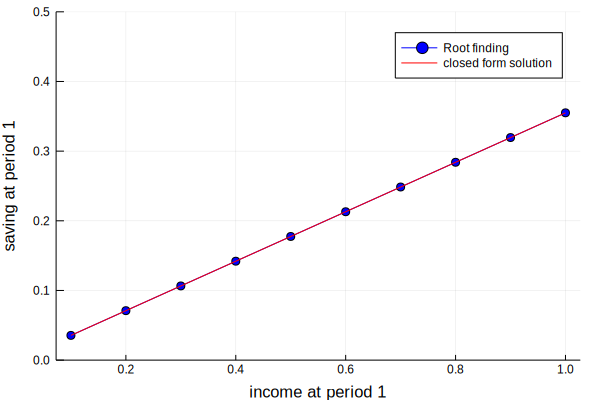

In [25]:
plot(model.grid_w, a_nl, color = :blue, marker=:circle, label="Root finding")
plot!(model.grid_w, a_cfs, color = :red, label="closed form solution" )
ylims!((0, 0.5))
xlabel!("income at period 1")
ylabel!("saving at period 1")

In [26]:
function resid_ex(m::Models)
    """
    本文中の残差についての図を書くための関数
    """
    
    resid = zeros(m.na,3)
    grid_zero = zeros(m.na)

    wlist = [0.5, 0.8, 1.0]
    for (w_ind, w_val) in enumerate(wlist)
        resid_two_period!(a) = resid_two_period(a, w_val, m)
        for j in 1:m.na
            resid[j,w_ind] = resid_two_period!(m.grid_a[j])
        end
    end
    return resid, grid_zero
end

resid_ex (generic function with 1 method)

In [27]:
resid, grid_zero = resid_ex(model)

([108.365 290.135 459.787; 23.5389 67.1637 108.365; … ; -0.999968 -0.999968 -0.999801; -0.99997 -0.99997 -0.99997], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

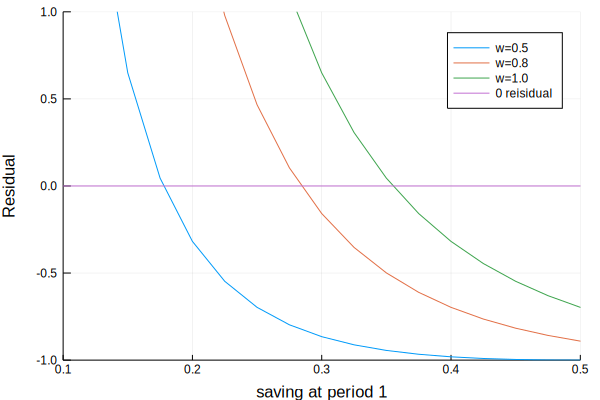

In [28]:
plot(model.grid_a, resid, label=["w=0.5", "w=0.8", "w=1.0"])
plot!(model.grid_a, grid_zero, label="0 reisidual")
xlims!((0.1, 0.5))
ylims!((-1.0, 1.0))
xlabel!("saving at period 1")
ylabel!("Residual")

## 射影法

In [29]:
function approx_policy(coef, eval)
    """
    政策関数を多項式によって近似する
    
    # インプット
    `coef`: 多項式の係数
    `eval::Vector:選点
    
    # アウトプット
    `next_a::Matrix`:2期における資産水準
    """
    
    dim_app = length(coef) -1 
    nw = length(eval)
    XX = zeros(nw, dim_app+1)
    for i in 0:dim_app
        XX[:,i+1] = eval.^i
    end 
    next_a = XX*coef
    return next_a
end

approx_policy (generic function with 1 method)

In [30]:
function resid_projection(coef, m::Models)
    """
    選点に基づいてオイラー方程式の残差を返す
    
    # インプット
    `coef`:多項式の係数
    `m::Models`:パラメータを含む構造体
    
    # アウトプット
    `residual::Vector`:残差
    """
    
    a = approx_policy(coef, m.grid_w) #1期目の貯蓄
    
    c1 = m.grid_w - a #1期目の消費
    c2 = (1.0+m.rent)*a #2期目の消費
    ng = length(c1) # 次元を取り出す
    mu1 = zeros(ng) #1期における限界効用
    mu2 = similar(mu1) #2期における限界効用
    resid = similar(mu1) #残差
    for i in 1:ng
        if c1[i] > 0.0
            mu1[i] = mu_CRRA(c1[i], m.γ)
        else
            mu1[i] = 10000.0 #負の消費に対するペナルティ
        end
        
        if c2[i] > 0.0
            mu2[i] = mu_CRRA(c2[i], m.γ)
        else
            mu2[i] = 10000.0 #負の消費に対するペナルティ
        end
        resid[i] = m.β*(1.0+m.rent)*(mu2[i]/mu1[i]) - 1.0
    end

    return resid
end

resid_projection (generic function with 1 method)

In [31]:
function projection(m::Models, coef_init=[0.1, 0.35])
    """
    射影法によって2期間モデルを解く
    
    # インプット
    `m::Models`: パラメータを含む構造体
    `coef_init::Vector`:係数の初期予想
    
    # アウトプット
    `res.minimizer`:非線形最小二乗法によって得られた係数
    `res.converged::Bool`:最小二乗法が収束したかを示す変数
    `next_a`:射影法によって得られる政策関数
    """
    
    # 多項式の次元を決定
    #dim_app = 1　今回のコーディングでは必要としない
    resid_projection!(coef) = resid_projection(coef, m)
    
    # レーベンバーグ・マルカート法で非線形最小二乗法を行う
    # LeastSquaresOptim.jl パッケージを利用 QuantEcon参照
    res = LeastSquaresOptim.optimize(resid_projection!, 
                                     coef_init, LevenbergMarquardt())
    
    #ゼロ点探索によって得た係数を使って政策関数を求める
    next_a = approx_policy(res.minimizer, m.grid_w)
    
    return res.minimizer, res.converged , next_a
end

projection (generic function with 2 methods)

In [32]:
res = projection(model)

([1.01407e-12, 0.355009], true, [0.0355009, 0.0710018, 0.106503, 0.142004, 0.177504, 0.213005, 0.248506, 0.284007, 0.319508, 0.355009])

In [33]:
@benchmark projection(model)

BenchmarkTools.Trial: 
  memory estimate:  903.88 KiB
  allocs estimate:  1081
  --------------
  minimum time:     182.656 μs (0.00% GC)
  median time:      194.997 μs (0.00% GC)
  mean time:        276.159 μs (21.60% GC)
  maximum time:     2.608 ms (89.62% GC)
  --------------
  samples:          10000
  evals/sample:     1

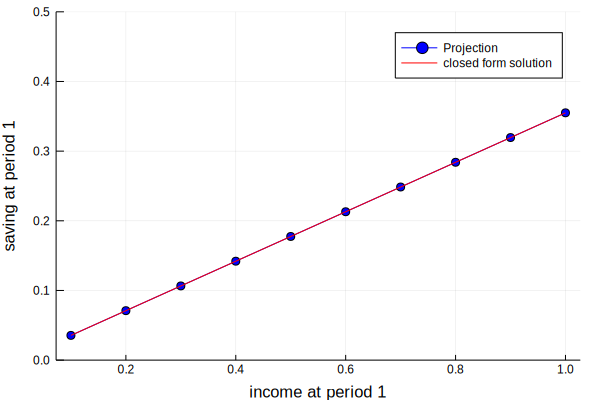

In [34]:
plot(model.grid_w, res[3], color = :blue, marker=:circle, label="Projection")
plot!(model.grid_w, a_cfs, color = :red, label="closed form solution" )
ylims!((0, 0.5))
xlabel!("income at period 1")
ylabel!("saving at period 1")

## まとめ

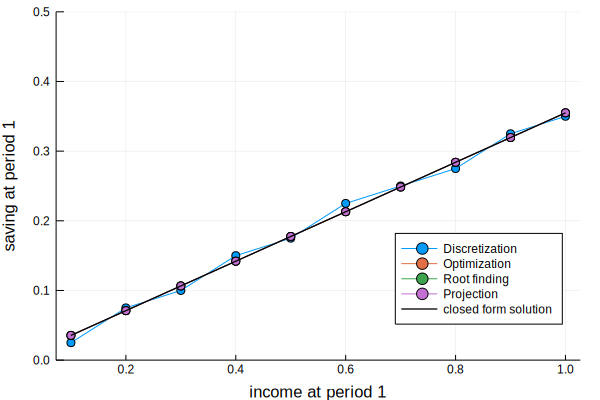

In [35]:
plot(model.grid_w, pol, marker=:circle, label="Discretization",legend=:bottomright)
plot!(model.grid_w, a_gs, marker=:circle, label="Optimization")
plot!(model.grid_w, a_nl, marker=:circle, label="Root finding")
plot!(model.grid_w, res[3], marker=:circle, label="Projection")
plot!(model.grid_w, a_cfs, color = :black,linewidth= 1.3, label="closed form solution" )
ylims!((0, 0.5))
xlabel!("income at period 1")
ylabel!("saving at period 1")

以上より最適化、求根アルゴリズム、射影法は解析解と非常に近い解を得ることが出来ることが分かった。